## Imports

In [1]:
import pandas as pd
import math
import numpy as np
import plotly.graph_objs as go

from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import chebyshev
import itertools

import xgboost

import shap
import openml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from collections import defaultdict
from collections import Counter

from matplotlib import pyplot as plt

import pickle

## Function to calculate SHAP values

In [2]:
import pandas as pd
import numpy as np
import itertools
from numba import njit, jit

"""
------------------------------------------
General SHAP computation helper functions.
------------------------------------------
"""

@njit
def find_index(array, item):
    """
    Accelerated index finder.
    """
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]

def computeb1b2(x, w, o, i, pre_idx, order=-1, prng=None):
    """
    Compute b1 and b2 for order sample o, instance sample w, and feature index i.
    
    Parameters
    ----------
    w : numpy array
        array of size n with feature values of instance (w)
    o : numpy array 
        array of size n with order of features
    i : int
        feature index
    pre_idx : numpy array
        arrangement of feature indices
    """
    pos_i = find_index(o, i) # pos_i = np.where(o == i)[0][0]
    idx = pre_idx[pos_i + 1:] # positions succeeding i 
    o_idx = o[idx] # features succeeding i
    b1 = x.copy()
    b1[o_idx] = w[o_idx] # fill features succeeding i with w
    b2 = b1.copy()
    b2[i] = w[i] # change x_i to w_i    
    return b1, b2

"""
-----------------------------------
Exact computation helper functions.
-----------------------------------
"""

def retrieve_instances(mc, X):
    """
    Retrieve all 
    """
    if mc == 'uniform-cat':
        z = [X[c].unique() for c in X.columns]
        instances = list(itertools.product(*z))
    elif mc == 'training':
        instances = X.as_matrix()
    return instances

def retrieve_permutations(n):
    permutations = list(itertools.permutations(range(n)))
    return permutations

"""
-----------------------------------
Adaptive Sampling helper functions.
-----------------------------------
"""
def update(existingAggregate, newValue):
    """
    Update the count, mean, and mean square.
    
    Welford's online algorithm for calculating variance.
    
    existingAggretate : tuple
        (count, mean, M2)
    newValue : float
        f(b1) - f(b2) for newest sample
    """
    (count, mean, M2) = existingAggregate
    count += 1 
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    sampleVariance = M2/(count - 1)
    return count, mean, M2, sampleVariance

"""
-------------
SHAP classes.
-------------
"""

class Generator:
    """
    Generator for instaces (w)
    """
    def __init__(self, X, mc):
        """
        Paramaters
        ----------
        X : pandas DataFrame
            Training data for sampling instances (w)
        mc : string
            - 'training' : sample instances (w) from training data
        """
        self.mc = mc
        self.feature_generators = {}
        self.columns = X.columns.tolist()
        if mc == 'training':
            self.X = X
        else: 
            raise ValueError("'%s' is an invalid Monte Carlo sampling strategy." % self.mc)
        return

    def sample(self, n, seed = 1, sample_type = 'dict', replace = True):
        """
        Sample n ranodm instances (w).
        Parameters
        ----------
        n : int
            number of samples
        seed : int
            pseudorandom seed
        replacement : Boolean
            sample with replacement (True) or without replacement (False)
        Returns
        -------
        samples : numpy array
            two dimensional numpy array of feature * instances
        """
        if self.mc == 'training':
            samples = self.X.sample(n = n, random_state = seed, replace = replace)
        return samples

class Values:
    """
    Store SHAP values and samples.
    """
    def __init__(self, shap_values, abs_shap_values, samples = None):
        self.shap_values = shap_values
        self.abs_shap_values = abs_shap_values
        self.samples = samples
        return

class Explainer:
    """
    Object that can be called to compute SHAP values. Stores training data, classifier and sampling parameter.
    """

    def __init__(self, X, mc = 'training', f = None):
        """
        Paramaters
        ----------
        X : pandas DataFrame
            Training data for sampling instances (w)
        mc : string
            - 'training' : sample instances (w) from training data
        """
        self.X = X
        self.mc = mc
        self.f = f
        return

    def standard(self, x, m, f = None, X = None, mc = None, seed = 1, verbose = False, return_samples=False):

        """
        Naive Monte Carlo approximation of SHAP values.
        
        Parameters
        ----------
        x : numpy array
            numpy array containing all feature values, features must be ordered according to dataframe
        f : object
            model should have function '.predict_proba()' that takes as input an instance and as 
            output a probability for the positive class
        m : int
            number of samples for each feature
        X : pandas DataFrame
            training dataset
        mc : string
            Monte Carlo sampling strategy that indicates how random instances are sampled.
            The sampling strategy affects the computation of the conditional expectation.
            'training' : random instances will be sampled from the training data
        seed : int
            seed used for generating random instances and choosing random orders
        verbose : Boolean
            controls verbosity
        return_samples : Boolean
            returning samples that were used to commpute SHAP values to allow for SHAP-ICE and SHAP-ICC plots.
        """

        # Retrieve explainer variables
        X, mc, f = self.X, self.mc, self.f
        
        # Initialize vars
        features = np.arange(len(X.columns)).astype(int) # numpy array with feature indexes
        n = len(features)
        chi = Generator(X=X, mc=mc)
        phi = {}
        abs_phi = {}
        pre_idx = np.arange(len(features)) 

        # Sample all permutations (o)
        prng = np.random.RandomState(seed=seed)
        permutations = [prng.permutation(range(n)) for i in range(m*n)]
        
        # Sample all instances (w)
        samples = np.array(chi.sample(n=m*n, seed=seed, sample_type = 'array'))
        
        #TEMP
        temp_results = {}
        
        # Compute all b1 and b2
        b1_all = [0]*(m*n) # initialize list with all b1's
        b2_all = [0]*(m*n) # initialize list with all b2's
        for i, index_n in zip(features, range(n)): # for each feature
            temp_feature_results = []
            for w, o, index_m in zip(samples[index_n*m:(index_n+1)*m], permutations[index_n*m:(index_n+1)*m], range(m)):
                # for each sample index_m, consisting of instance w and order o:
                b1, b2 = computeb1b2(x, w, o, i, pre_idx)
                all_index = index_n*m + index_m
                b1_all[all_index] = b1
                b2_all[all_index] = b2
                # TEMP
                temp_feature_results.append({'o' : tuple(o), 'w' : w, 'b1' : b1, 'b2' : b2, 'v' : w[i]})
            temp_results[i] = pd.DataFrame(temp_feature_results)

        # Make predictions for instances b1 and b2
        predictions = np.array(f.predict_proba(b1_all + b2_all))[:, 1]
        if verbose:
            print("Average predictions b1/b2: %.5f" %(np.mean(predictions)))

        # Compute Shapley value based on marginal contributions
        for i, j in zip(X.columns, features):
            b1_i = predictions[(j*m):(j+1)*m]
            b2_i = predictions[(n*m+j*m):(n*m+(j+1)*m)]
            phi[i] = sum(b1_i-b2_i)/m
            abs_phi[i] = sum([abs(diff) for diff in (b1_i-b2_i)])/m
            
            # TEMP
            temp_results[j]['f(b1)'] = b1_i
            temp_results[j]['f(b2)'] = b2_i
            temp_results[j]['c'] = b1_i - b2_i
        if return_samples:
            return Values(phi, abs_phi, samples = temp_results)
        else:
            return Values(phi, abs_phi)

## Load Dataset

In [3]:
def label_encode(df, cat_variables):
    dataframe = df.copy()
    label_dictionary = defaultdict(LabelEncoder)
    dataframe[cat_variables] = dataframe[cat_variables].apply(lambda x: label_dictionary[x.name].fit_transform(x))
    return dataframe, label_dictionary


def label_decode(df, cat_variables, label_dictionary):
    dataframe = df.copy()
    dataframe[cat_variables] = dataframe[cat_variables].apply(lambda x: label_dictionary[x.name].inverse_transform(x))
    return dataframe


def label_encode_new(df, cat_variables, label_dictionary):
    dataframe = df.copy()
    dataframe[cat_variables] = dataframe[cat_variables].apply(lambda x: label_dictionary[x.name].transform(x))
    return dataframe

In [4]:
def load_dataset(dataset_name):
    if dataset_name == 'Adult':
        X, y = shap.datasets.adult(display=True)

        X['TF'] = y
        X = X[(X[X.columns] != ' ?').all(axis=1)]
        X.reset_index(drop=True, inplace=True)
        X.drop_duplicates(inplace=True)
        X, y = X.loc[:, X.columns != 'TF'], X['TF']
        y = np.array(y)

        num_features = ['Age', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
        cat_features = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']

        # convert float to int
        X['Education-Num'] = X['Education-Num'].astype(int)
        X['Age'] = X['Age'].astype(int)
        X['Hours per week'] = X['Hours per week'].astype(int)

        X_enc, encode_dict = label_encode(X, cat_features)
        y_enc = y

        X_train_testA, X_testB, y_train_testA, y_testB = train_test_split(X_enc, y_enc, train_size=6000,
                                                                          test_size=2000, random_state=7)
        X_train, X_testA, y_train, y_testA = train_test_split(X_train_testA, y_train_testA, train_size=4000,
                                                              test_size=2000, random_state=7)
        
        return X_train_testA, X_train, X_testA, X_testB, y_train_testA, y_train, y_testA, y_testB
        
    elif dataset_name == 'Churn':
        dataset = openml.datasets.get_dataset(40701)

        X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format='dataframe',
            target=dataset.default_target_attribute
        )
        
        y.replace('0', False, inplace=True)
        y.replace('1', True, inplace=True)
        
        y = y.values
        
        X_train_testA, X_testB, y_train_testA, y_testB = train_test_split(X, y, train_size=4000,
                                                                          test_size=1000, random_state=7)
        X_train, X_testA, y_train, y_testA = train_test_split(X_train_testA, y_train_testA, train_size=3000,
                                                              test_size=1000, random_state=7)
        
        return X_train_testA, X_train, X_testA, X_testB, y_train_testA, y_train, y_testA, y_testB
    
    elif dataset_name == 'Phoneme':
        dataset = openml.datasets.get_dataset(1489)

        X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format='dataframe',
            target=dataset.default_target_attribute
        )
        
        y.replace('1', False, inplace=True)
        y.replace('2', True, inplace=True)
        
        y = y.values
        
        X_train_testA, X_testB, y_train_testA, y_testB = train_test_split(X, y, train_size=4000,
                                                                          test_size=1000, random_state=7)
        X_train, X_testA, y_train, y_testA = train_test_split(X_train_testA, y_train_testA, train_size=3000,
                                                              test_size=1000, random_state=7)
        
        return X_train_testA, X_train, X_testA, X_testB, y_train_testA, y_train, y_testA, y_testB
    
    elif dataset_name == 'Magic Telescope':
        dataset = openml.datasets.get_dataset(1120)

        X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format='dataframe',
            target=dataset.default_target_attribute
        )
        
        y.replace('g', False, inplace=True)
        y.replace('h', True, inplace=True)
        
        y = y.values
        
        X_train_testA, X_testB, y_train_testA, y_testB = train_test_split(X, y, train_size=6000,
                                                                          test_size=2000, random_state=7)
        X_train, X_testA, y_train, y_testA = train_test_split(X_train_testA, y_train_testA, train_size=4000,
                                                              test_size=2000, random_state=7)
        
        return X_train_testA, X_train, X_testA, X_testB, y_train_testA, y_train, y_testA, y_testB
        
        

## Function for calculate ROC at varying probability threshold

In [5]:
def calculate_roc_curve(dataset, model, model_name):
    
    # Load Dataset
    X_train_testA, X_train, X_testA, X_testB, y_train_testA, y_train, y_testA, y_testB = load_dataset(dataset)
    
    # Train Model
    model.fit(X_train, y_train)
    
    # Calculate SHAP
    explainer = Explainer(X = X_train, f = model)
    
    shap_train_testA = np.empty((0, len(X_train_testA.columns)))
    for i in range(0, len(X_train_testA.index)):
        values = explainer.standard(x=np.asarray(X_train_testA.iloc[i]), m=100, return_samples=True)
        shap_train_testA = np.append(shap_train_testA, [list(values.shap_values.values())], axis=0)
        
    shap_testB = np.empty((0, len(X_testB.columns)))
    for i in range(0, len(X_testB.index)):
        values = explainer.standard(x=np.asarray(X_testB.iloc[i]), m=100, return_samples=True)
        shap_testB = np.append(shap_testB, [list(values.shap_values.values())], axis=0)
    
    # Train NN
    neighbors = NearestNeighbors(n_neighbors=20, metric='euclidean')
    neighbors.fit(shap_train_testA)
    train_neighbor_distance, train_neighbor_index = neighbors.kneighbors(shap_testB, n_neighbors=20, return_distance=True)
    
    # Get predictions
    y_pred_train_testA = model.predict_proba(X_train_testA)[:,1]
    y_pred_testB = model.predict_proba(X_testB)[:,1]
    
    # Calculate trust score for different model probability threshold
    TS_all = []
    for thres in [0.0, 0.25, 0.5, 0.75, 1]:
        y_pred_tf_train_testA = (y_pred_train_testA >= thres)
        y_pred_tf_testB = (y_pred_testB >= thres)
        
        confusion_matrix = []

        for i in range(0, len(y_train_testA)):
            if y_train_testA[i] == True and y_pred_tf_train_testA[i] == True:
                confusion_matrix.append("TP")
            elif y_train_testA[i] == False and y_pred_tf_train_testA[i] == False:
                confusion_matrix.append("TN")
            elif y_train_testA[i] == False and y_pred_tf_train_testA[i] == True:
                confusion_matrix.append("FP")
            else:
                confusion_matrix.append("FN")
        
        # Calculate trust score for a given threshold
        TS = []

        for j in range(0, len(train_neighbor_distance)):
            total_dist = 0
            dist = 0
            for i in range(0, len(train_neighbor_index[j])):
                test_index = train_neighbor_index[j][i]
                test_distance = train_neighbor_distance[j][i]
                if train_neighbor_distance[j][i] == 0.0:
                    test_distance = np.min(train_neighbor_distance[j][0:][np.nonzero(train_neighbor_distance[j][0:])])
                if confusion_matrix[test_index] == 'TP':
                    #print("TP")
                    total_dist = total_dist + (1/test_distance)
                    dist = dist + (1/test_distance)
                elif confusion_matrix[test_index] == 'TN':
                    #print("TN")
                    total_dist = total_dist + (1/test_distance)
                    dist = dist + (1/test_distance)
                elif confusion_matrix[test_index] == 'FP':
                    #print("FP")
                    total_dist = total_dist + (1/test_distance)
                else:
                    #print("FN")
                    total_dist = total_dist + (1/test_distance)
            score = dist/total_dist
            TS.append(score)
            
        # Take complement of trust score for negative predictions in order to generate the ROC curve.    
        TS_curve = []
        for i in range(0, len(y_pred_tf_testB)):
            if y_pred_tf_testB[i] == True:
                TS_curve.append(TS[i])
            else:
                TS_curve.append((1 - TS[i]))
            
        TS_all.append(TS_curve)
                           
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharex=True, sharey=True,figsize=(30, 5))

    fig.text(0.5, 0.04, 'False Positive Rate or (1 - Specifity)', ha='center')
    fig.text(0.1, 0.5, 'True Positive Rate or (Sensitivity)', va='center', rotation='vertical')
    Title = 'Receiver Operating Characteristic for Trust Score' + ' (' + dataset + ' dataset, ' + model_name + ' model)'
    plt.suptitle(Title)
    
    # Compute fpr, tpr, thresholds and roc auc for model prediction
    fpr, tpr, thresholds = roc_curve(y_testB, y_pred_testB)
    roc_auc = auc(y_testB, y_pred_testB)

    # Plot ROC curve for model prediction
    ax1.plot(fpr, tpr, label='ROC curve model prob (area = %0.3f)' % roc_auc)
    ax2.plot(fpr, tpr, label='ROC curve model prob (area = %0.3f)' % roc_auc)
    ax3.plot(fpr, tpr, label='ROC curve model prob (area = %0.3f)' % roc_auc)
    ax4.plot(fpr, tpr, label='ROC curve model prob (area = %0.3f)' % roc_auc)
    ax5.plot(fpr, tpr, label='ROC curve model prob (area = %0.3f)' % roc_auc)
    
    # compute fpr, tpr, thresholds and roc auc for model prediction at different threshold
    
    fpr0, tpr0, thresholds0 = roc_curve(y_testB, np.array(TS_all[0]))
    roc_auc0 = auc(y_testB, np.array(TS_all[0]))
    
    fpr1, tpr1, thresholds1 = roc_curve(y_testB, np.array(TS_all[1]))
    roc_auc1 = auc(y_testB, np.array(TS_all[1]))
    
    fpr2, tpr2, thresholds2 = roc_curve(y_testB, np.array(TS_all[2]))
    roc_auc2 = auc(y_testB, np.array(TS_all[2]))
    
    fpr3, tpr3, thresholds3 = roc_curve(y_testB, np.array(TS_all[3]))
    roc_auc3 = auc(y_testB, np.array(TS_all[3]))
    
    fpr4, tpr4, thresholds4 = roc_curve(y_testB, np.array(TS_all[4]))
    roc_auc4 = auc(y_testB, np.array(TS_all[4]))
    
    # Plot ROC curve for TS at different threshold
    ax1.plot(fpr0, tpr0, label='ROC trust score (area = %0.3f)' % roc_auc0)
    ax2.plot(fpr1, tpr1, label='ROC trust score (area = %0.3f)' % roc_auc1)
    ax3.plot(fpr2, tpr2, label='ROC trust score (area = %0.3f)' % roc_auc2)
    ax4.plot(fpr3, tpr3, label='ROC trust score (area = %0.3f)' % roc_auc3)
    ax5.plot(fpr4, tpr4, label='ROC trust score (area = %0.3f)' % roc_auc4)
    
    ax1.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax1.title.set_text('Prediction threshold = 0')
    ax1.legend(loc="lower right")

    ax2.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax2.title.set_text('Prediction threshold = 0.25')
    ax2.legend(loc="lower right")

    ax3.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax3.title.set_text('Prediction threshold = 0.5')
    ax3.legend(loc="lower right")

    ax4.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax4.title.set_text('Prediction threshold = 0.75')
    ax4.legend(loc="lower right")

    ax5.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax5.title.set_text('Prediction threshold = 1')
    ax5.legend(loc="lower right")
    
    return TS_all

# ROC Trust Score for Logistic Regression Model

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



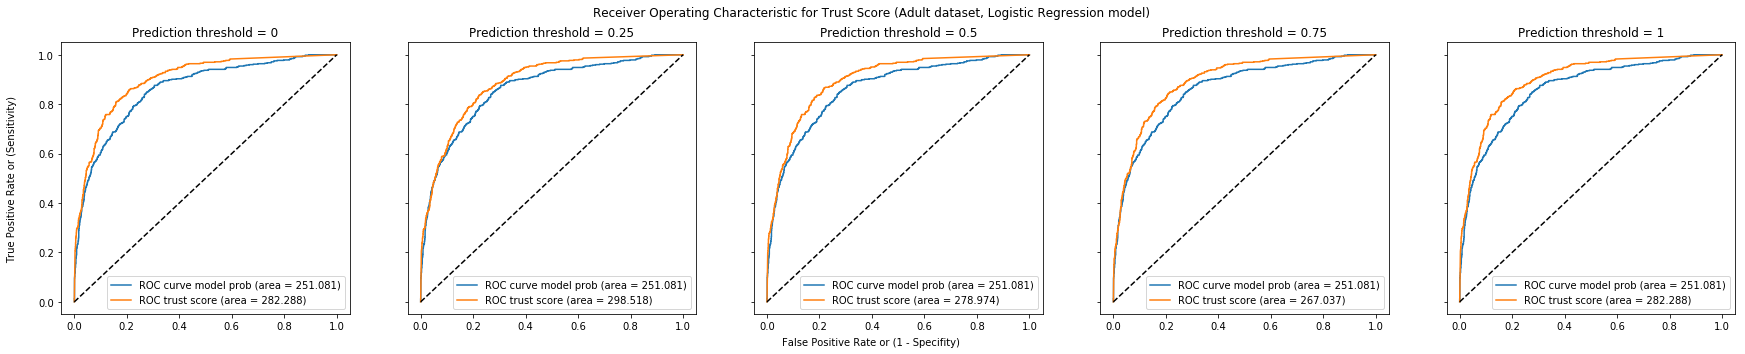

In [207]:
TS_all_adult = calculate_roc_curve('Adult', LogisticRegression(), 'Logistic Regression')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



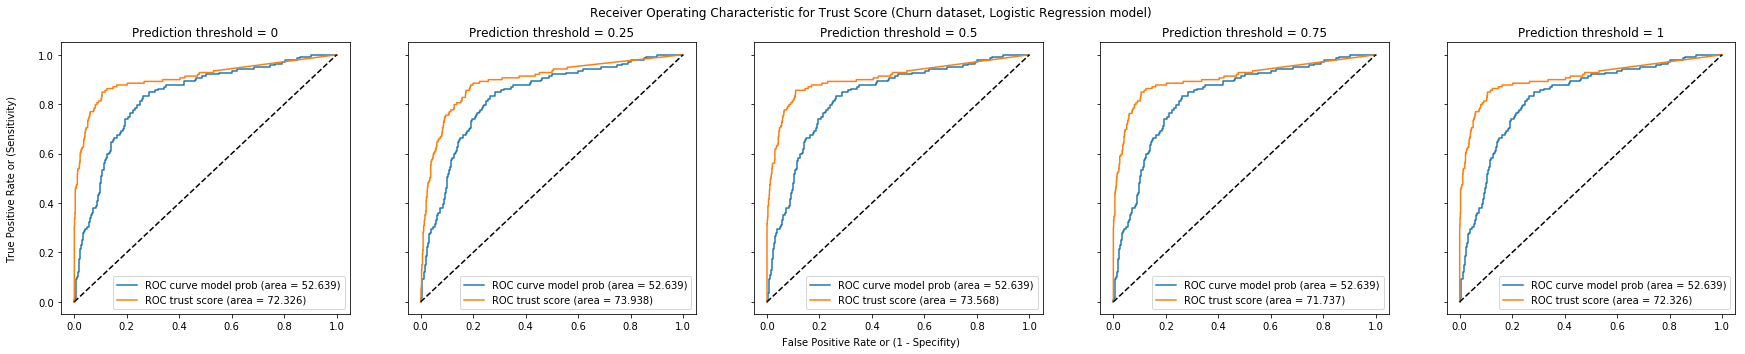

In [221]:
TS_all_churn = calculate_roc_curve('Churn', LogisticRegression(), 'Logistic Regression')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



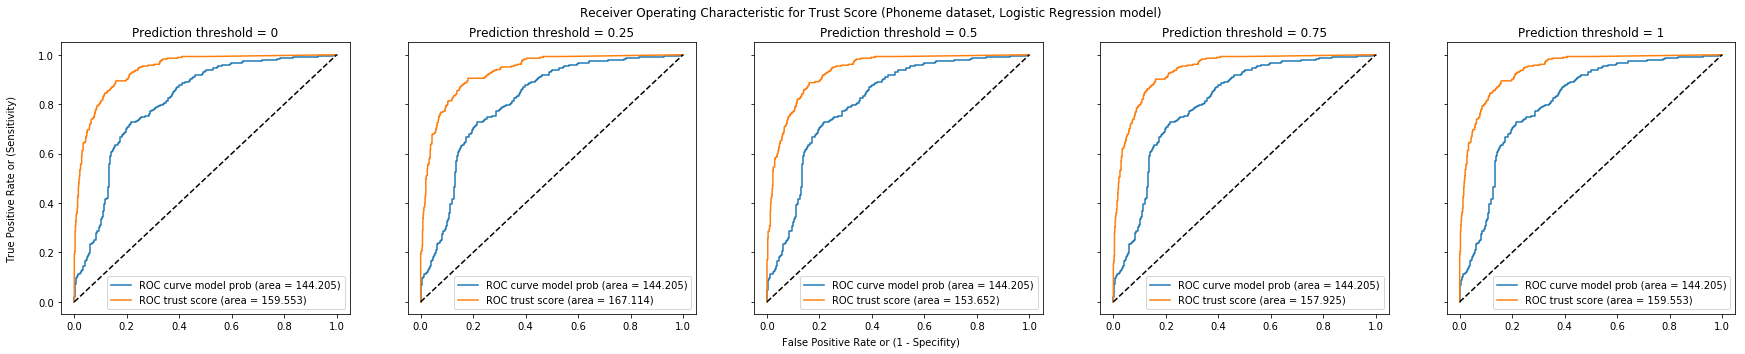

In [222]:
TS_all_phoneme = calculate_roc_curve('Phoneme', LogisticRegression(), 'Logistic Regression')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



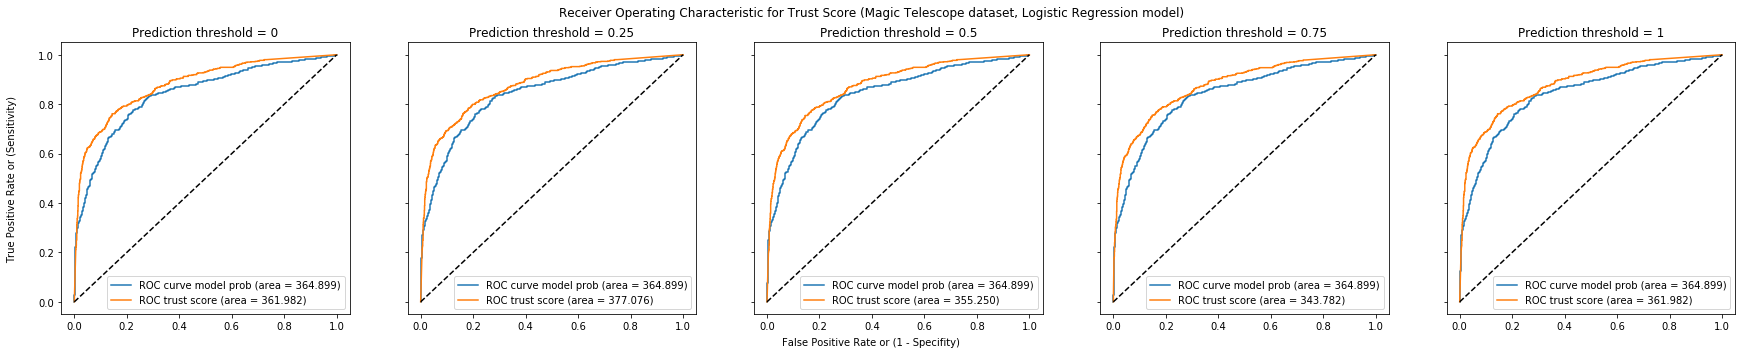

In [225]:
TS_all_magic = calculate_roc_curve('Magic Telescope', LogisticRegression(), 'Logistic Regression')

# ROC Trust Score for SVC  Model

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



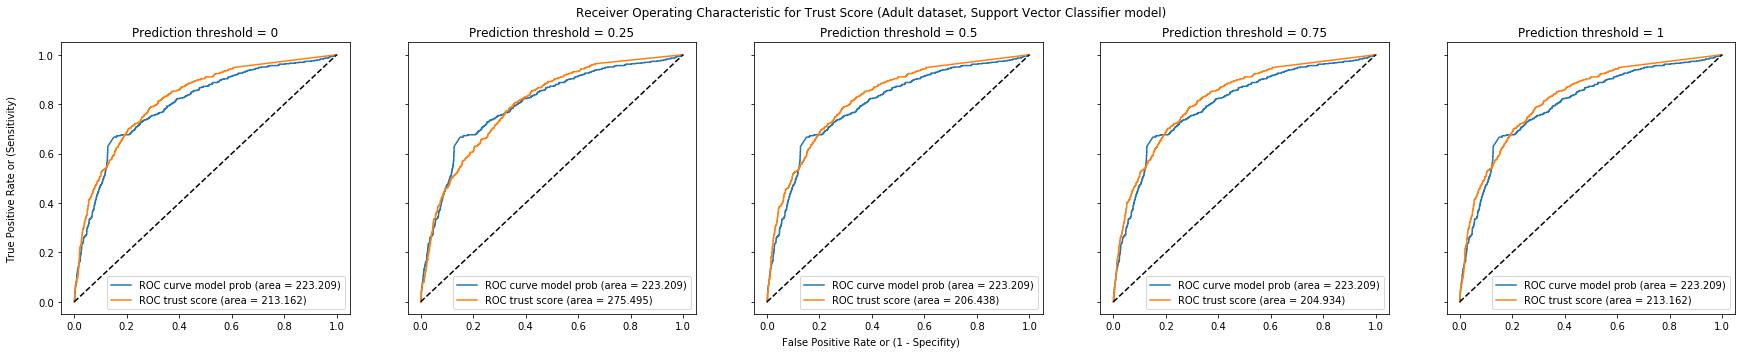

In [230]:
TS_all_adult = calculate_roc_curve('Adult', SVC(probability=True), 'Support Vector Classifier')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



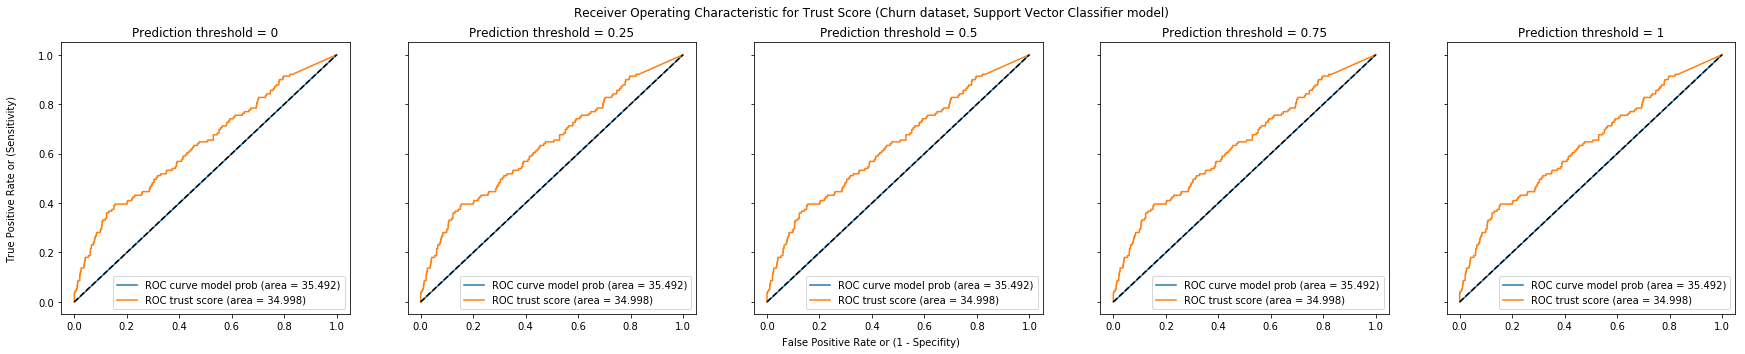

In [239]:
TS_all_churn = calculate_roc_curve('Churn', SVC(probability=True), 'Support Vector Classifier')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



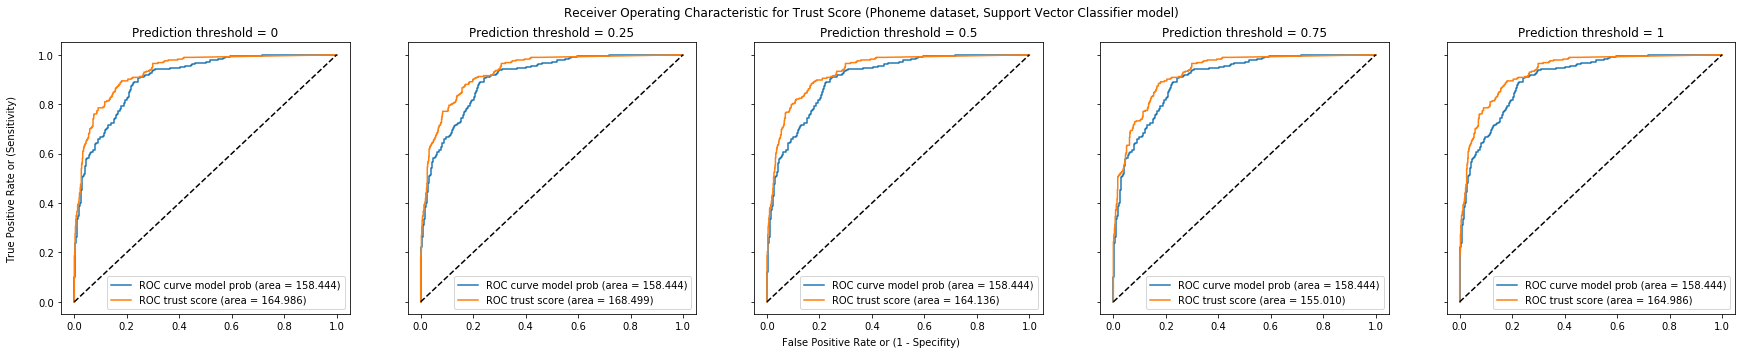

In [229]:
TS_all_phoneme = calculate_roc_curve('Phoneme', SVC(probability=True), 'Support Vector Classifier')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



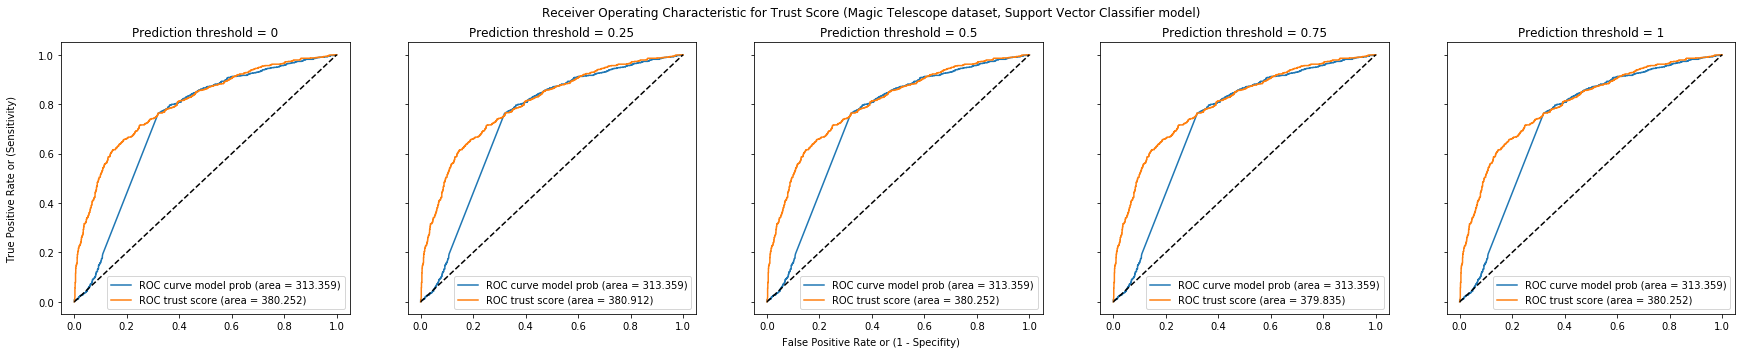

In [240]:
TS_all_magic = calculate_roc_curve('Magic Telescope', SVC(probability=True), 'Support Vector Classifier')

# ROC Trust Score for Naive Bayes  Model

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



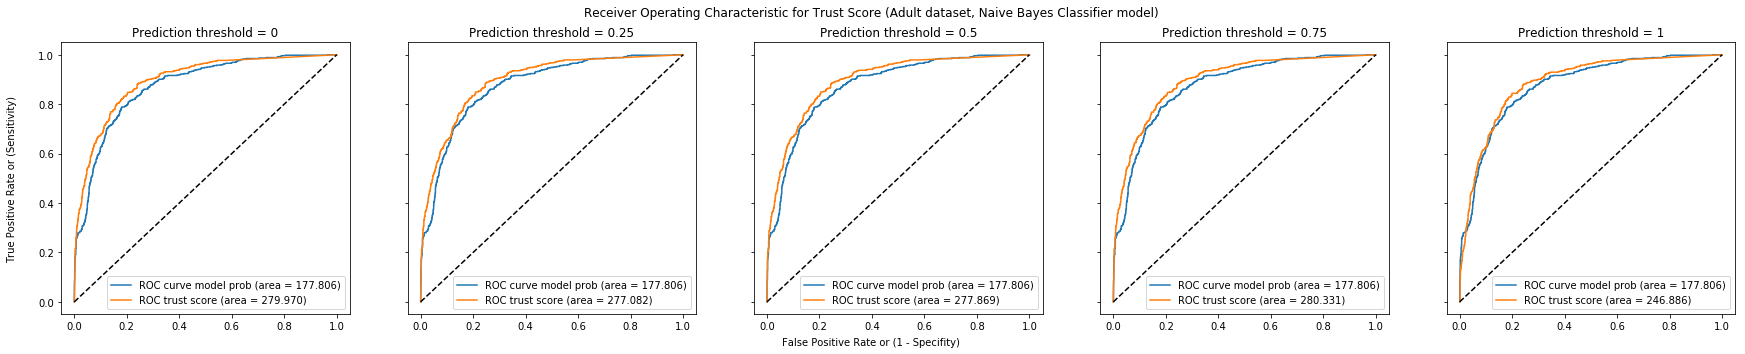

In [235]:
TS_all_adult = calculate_roc_curve('Adult', GaussianNB(), 'Naive Bayes Classifier')

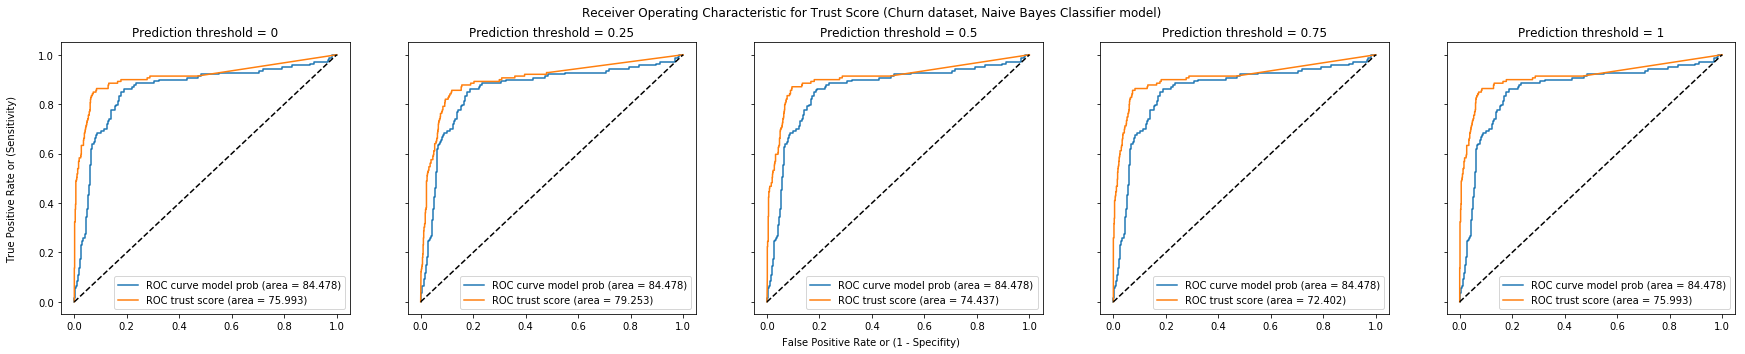

In [236]:
TS_all_churn = calculate_roc_curve('Churn', GaussianNB(), 'Naive Bayes Classifier')

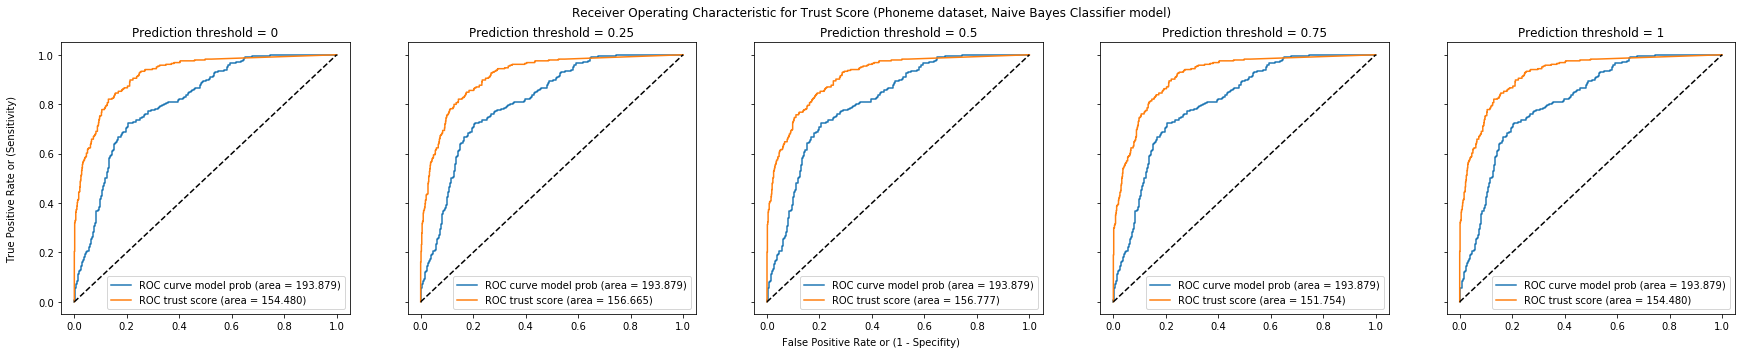

In [237]:
TS_all_phoneme = calculate_roc_curve('Phoneme', GaussianNB(), 'Naive Bayes Classifier')

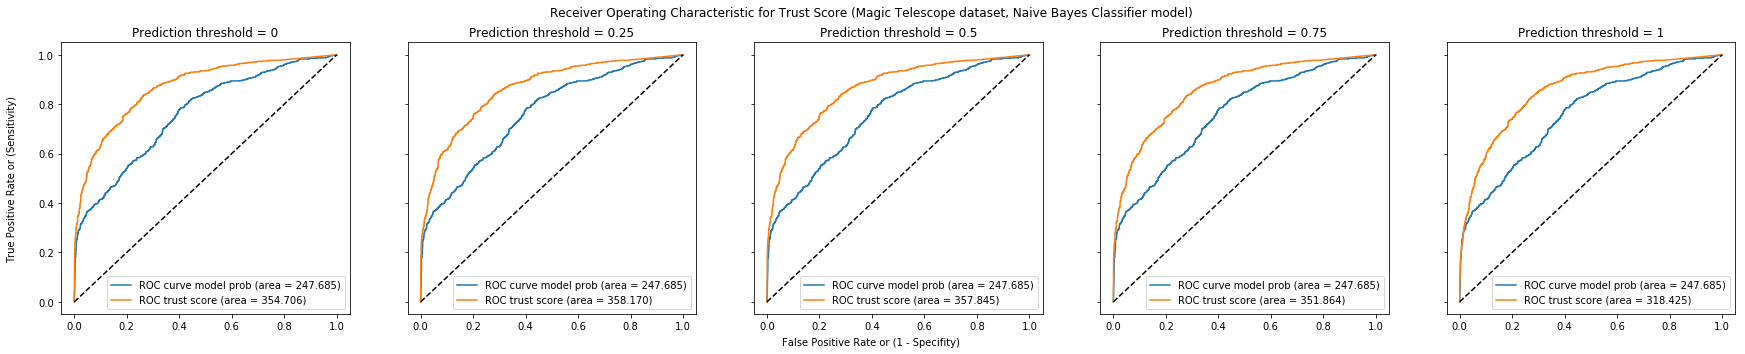

In [238]:
TS_all_magic = calculate_roc_curve('Magic Telescope', GaussianNB(), 'Naive Bayes Classifier')

# ROC Trust Score for Random Forest  Model

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



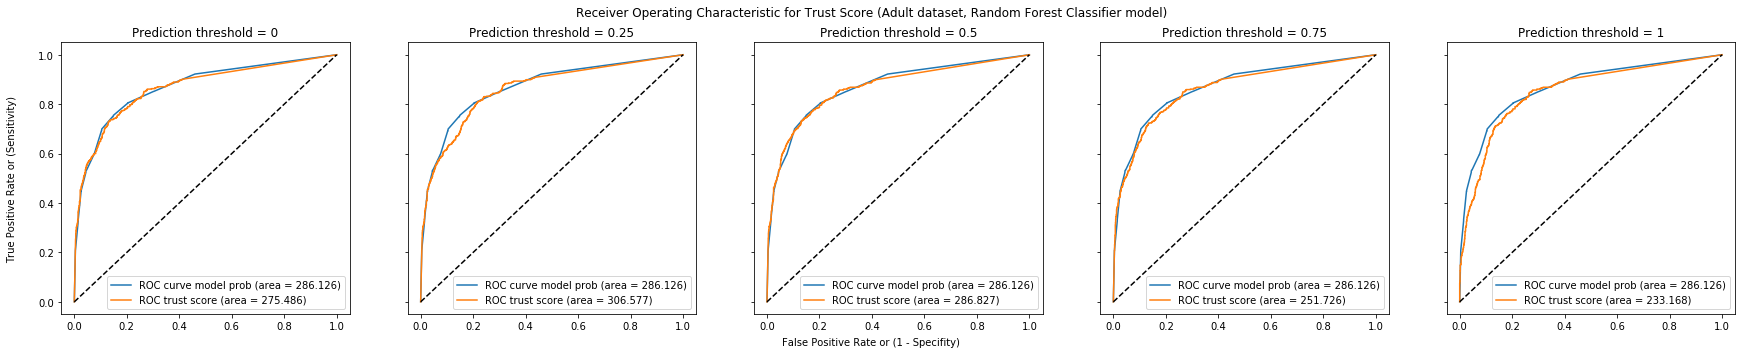

In [6]:
TS_all_adult = calculate_roc_curve('Adult', RandomForestClassifier(), 'Random Forest Classifier')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



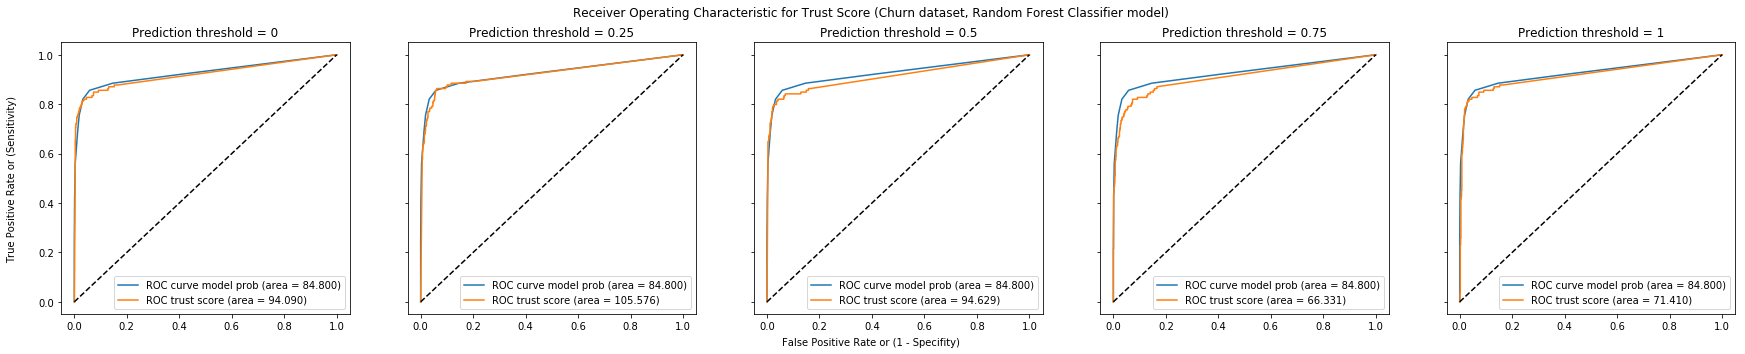

In [7]:
TS_all_churn = calculate_roc_curve('Churn', RandomForestClassifier(), 'Random Forest Classifier')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



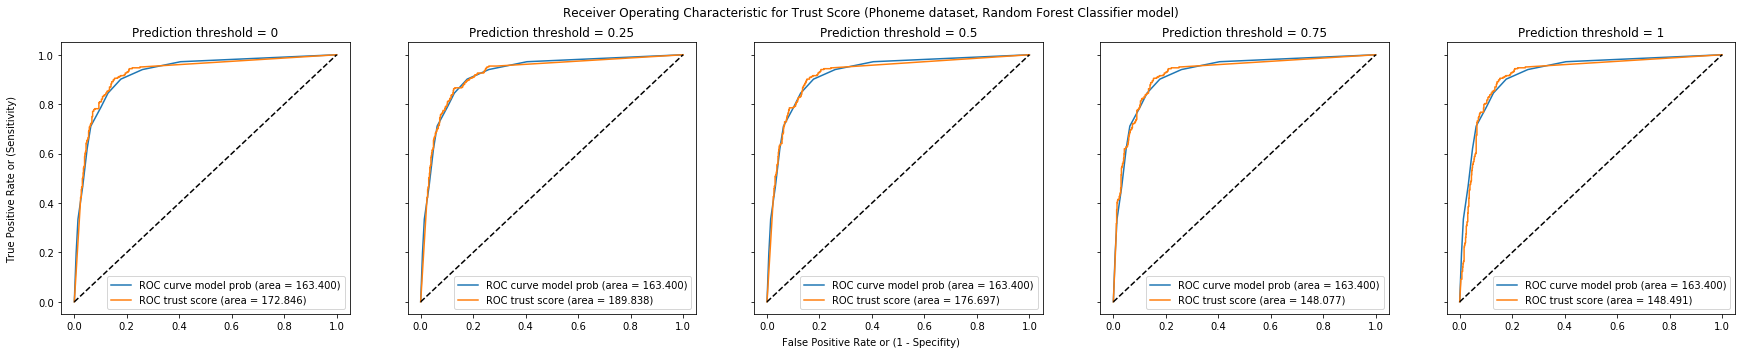

In [8]:
TS_all_phoneme = calculate_roc_curve('Phoneme', RandomForestClassifier(), 'Random Forest Classifier')

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



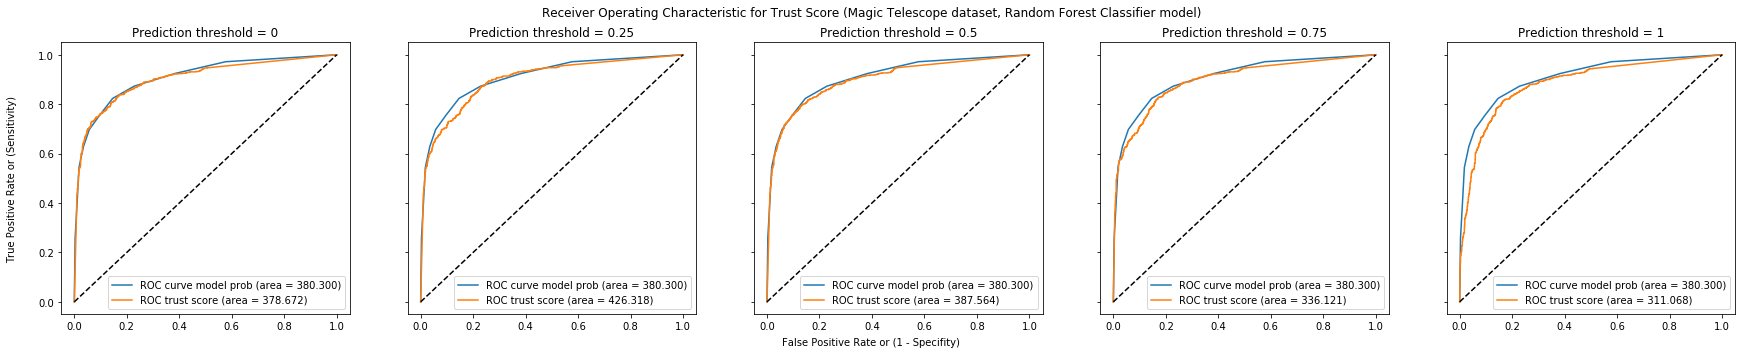

In [9]:
TS_all_magic = calculate_roc_curve('Magic Telescope', RandomForestClassifier(), 'Random Forest Classifier')